In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../modules')

import utils
from RateEchoStateNet import RateEchoStateNet as RateNet

import numpy as np
from numba import njit, prange
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate

# Generate data from Lorenz attractor

In [3]:
xyz0 = np.random.rand(3)
sigma = 10
rho = 28
beta = 8/3

start = 0
end = 300
Time = np.linspace(start, end, int(1e5))

solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = xyz0, args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True)
solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = solver.sol(end), args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True, method = 'DOP853')
xyz = solver.sol(Time).T

xyz -= xyz.min(axis = 0)
xyz /= xyz.max(axis = 0)

xyz = np.ascontiguousarray(xyz[::2])
Time = Time[::2]

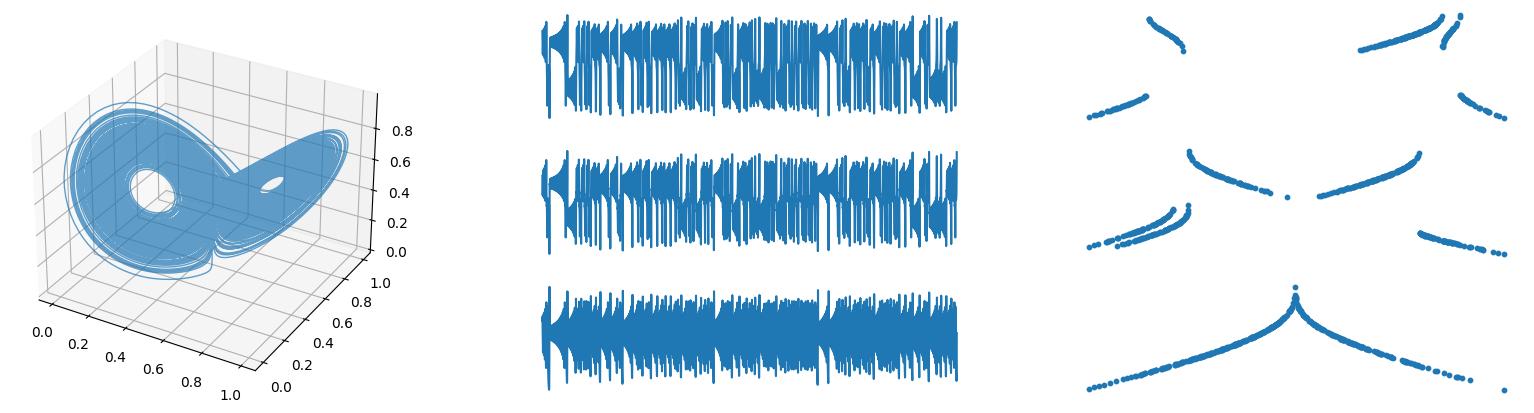

In [4]:
fig = plt.figure(figsize = (20,5))
axs = fig.subplot_mosaic('A03;A14;A25')
ss = axs['A'].get_subplotspec()
axs['A'].remove()
axs['A'] = fig.add_subplot(ss, projection='3d')
axs['A'].plot(*xyz.T, alpha=0.7, linewidth=1)

for i in range(3):
    axs[str(i)].plot(Time, xyz[:,i])
    axs[str(i)].axis('off')
    axs[str(i + 3)].scatter(*utils.return_map(xyz[:,i]), s = 10)
    axs[str(i + 3)].axis('off')
plt.show()

# Echo State Network

## Training example

In [13]:
N = 50
NE = int(0.8*N)
NI = int(0.2*N)
NIpunts = 3

dt = 0.05

tau_E = 1.
tau_I = 1.

net = RateNet(NE, NI, NIpunts, dt, tau_E, tau_I, burnSteps = None,
              input_sparse = 0.3, max_bias = None,
              method = 'rk4', nonlinearity = utils.sigmoid, args_nonlin = ())

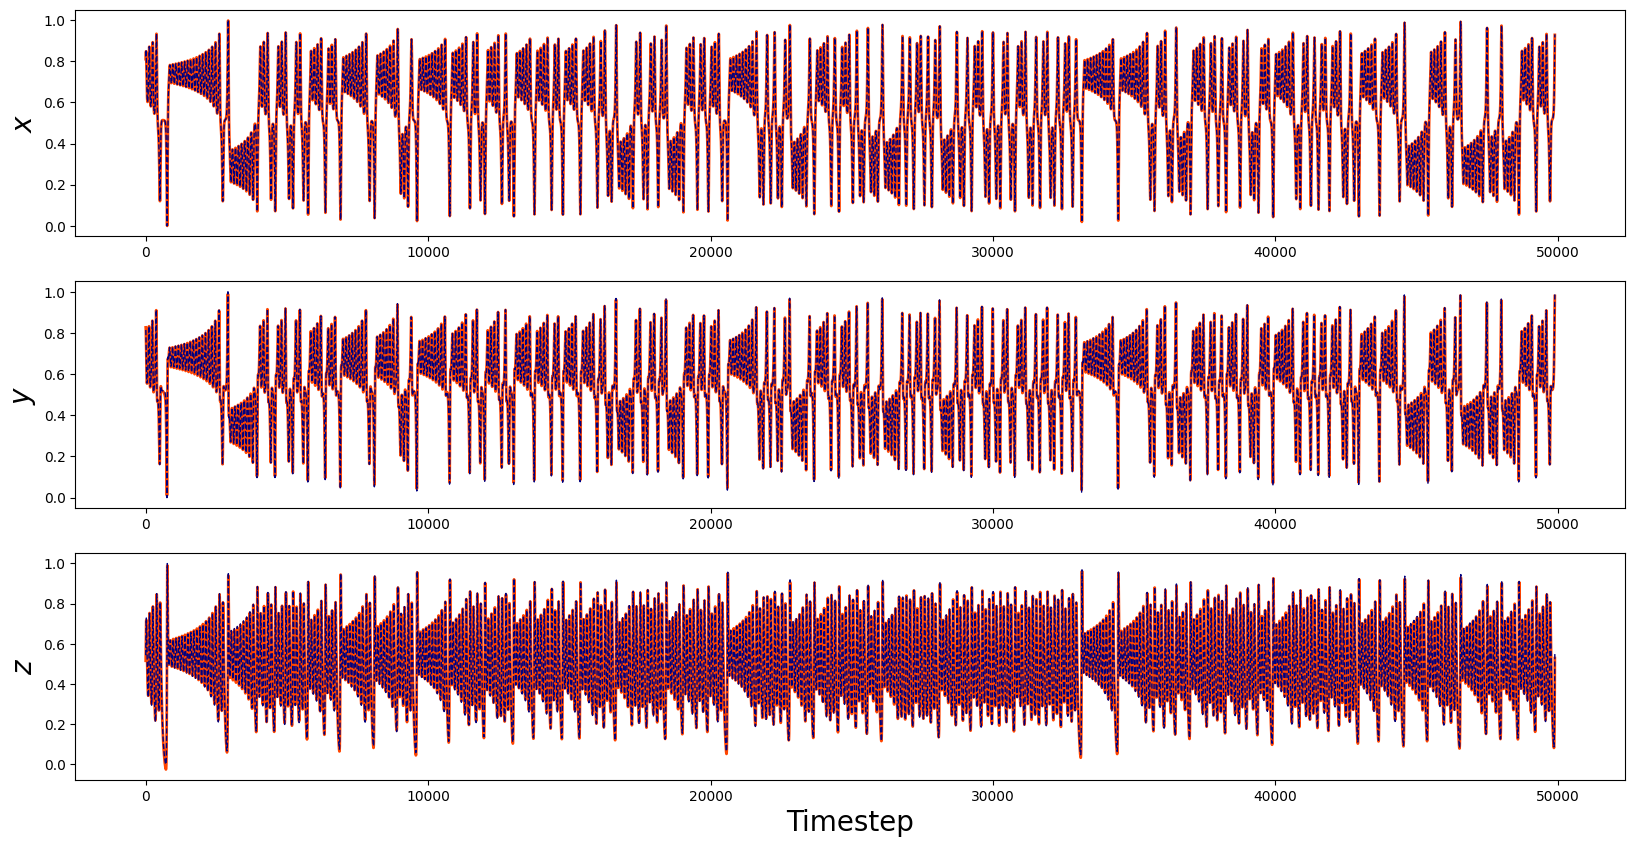

In [14]:
initTraining = 100
MSE, trained_output = net.train_model(xyz, initTraining, plot = True, alpha = 1e-3)

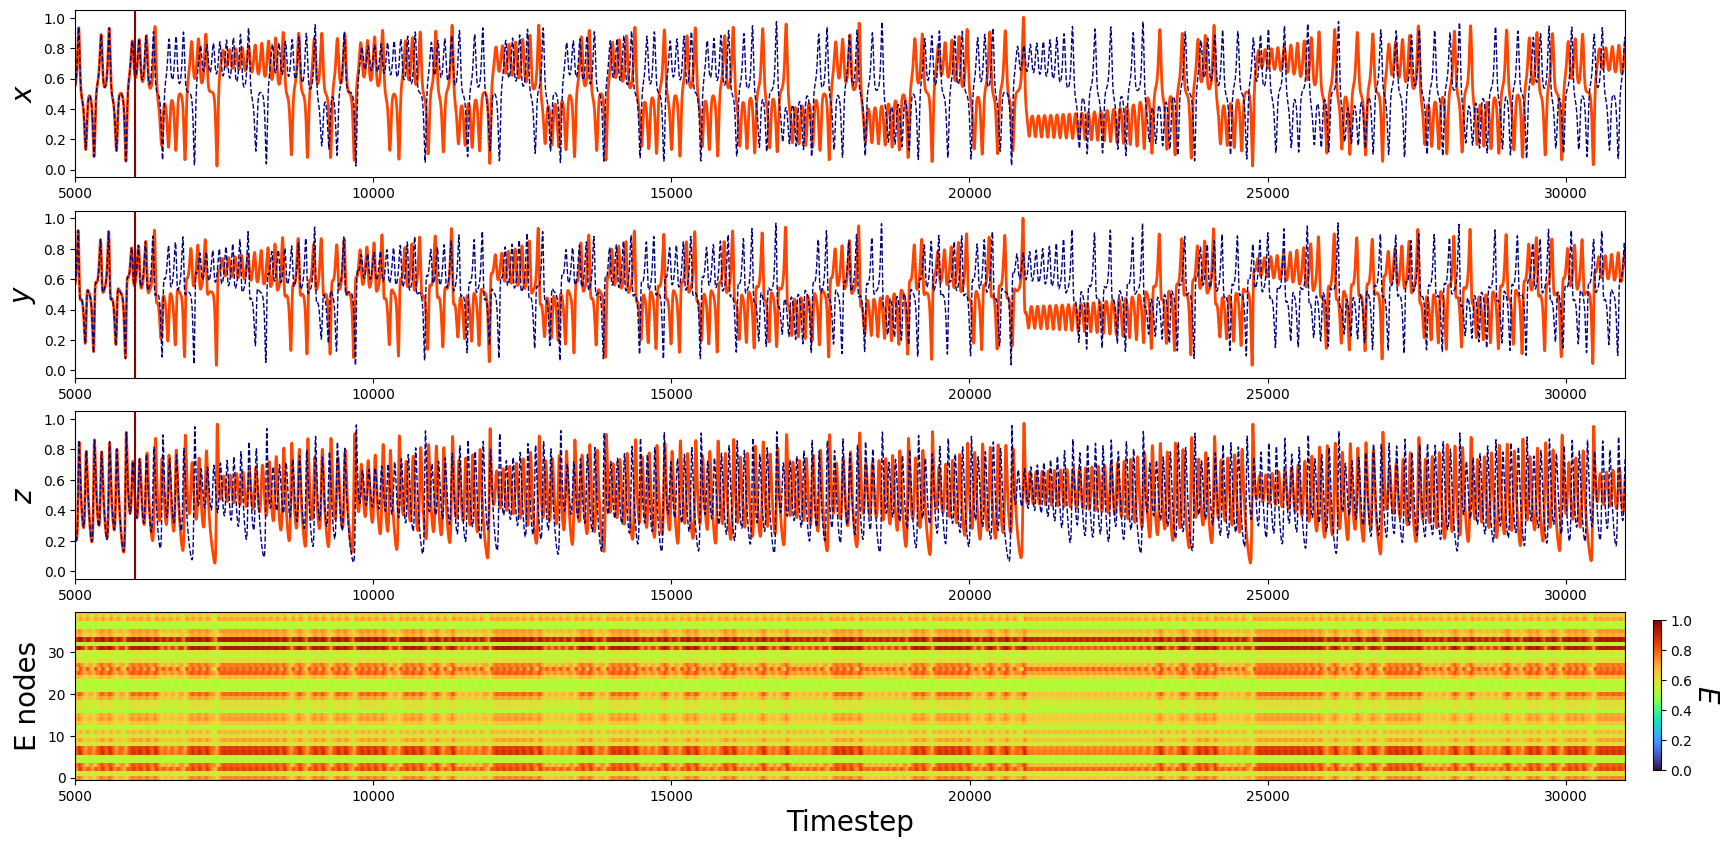

In [33]:
idx_start = 5000
idx_echo = 1000
nLoops = 25000
E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start, idx_echo = idx_echo,
                                             plot = True)

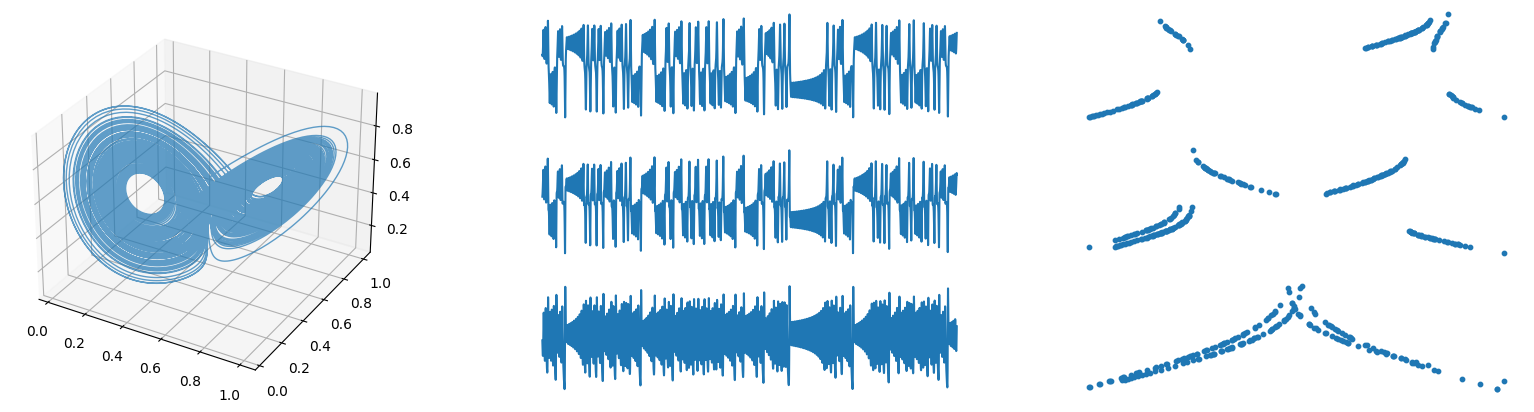

In [34]:
net.plot_attractor(output_echo[idx_echo:])

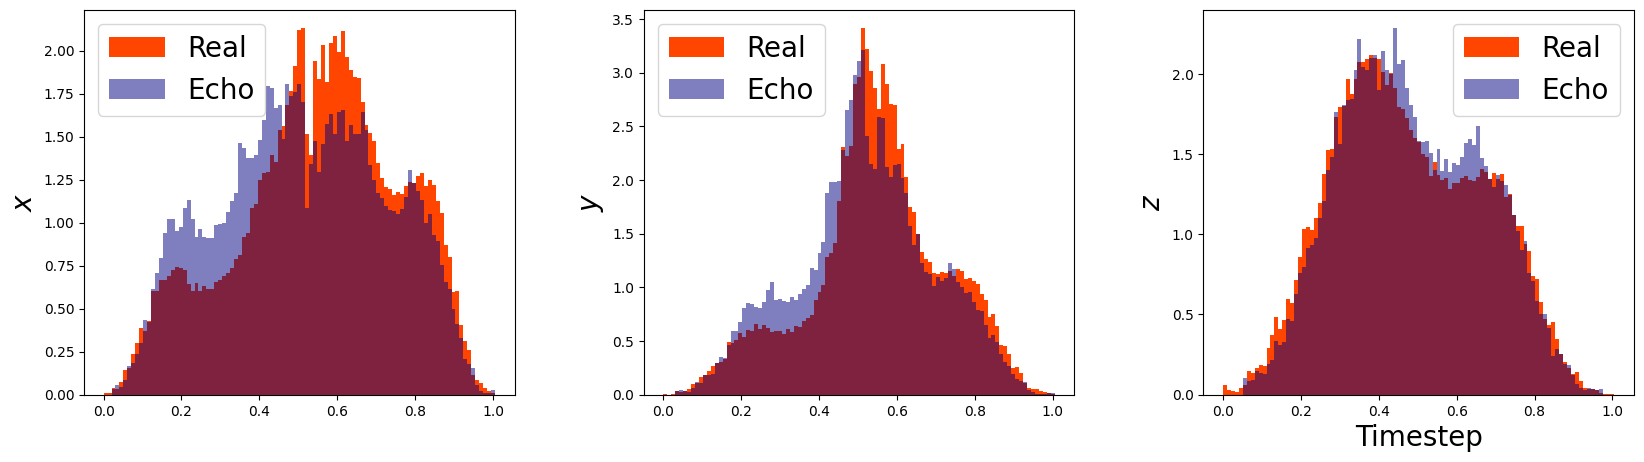

In [35]:
_ = net.compare_results(xyz, output_echo[idx_echo:], NBins = 100)

## Fit best Ridge regression parameter

In [36]:
N = 50
NE = int(0.8*N)
NI = int(0.2*N)
NIpunts = 3

dt = 0.05

tau_E = 1.
tau_I = 1.

net = RateNet(NE, NI, NIpunts, dt, tau_E, tau_I, burnSteps = None,
              input_sparse = 0.3, max_bias = None,
              method = 'rk4', nonlinearity = utils.sigmoid, args_nonlin = ())

In [41]:
idx_start = 5000
idx_echo = 1000
nLoops = 25000

net.fit_alpha(xyz, initTraining, idx_start, idx_echo, nLoops,
              alpha_min = 1e-8, alpha_max = 1e-1, NAlpha = 30)

New MSE: 2.12046 for alpha = 1e-08


In [42]:
net.alpha, net.MSE_echo

(1e-08, 2.1204566433499132)

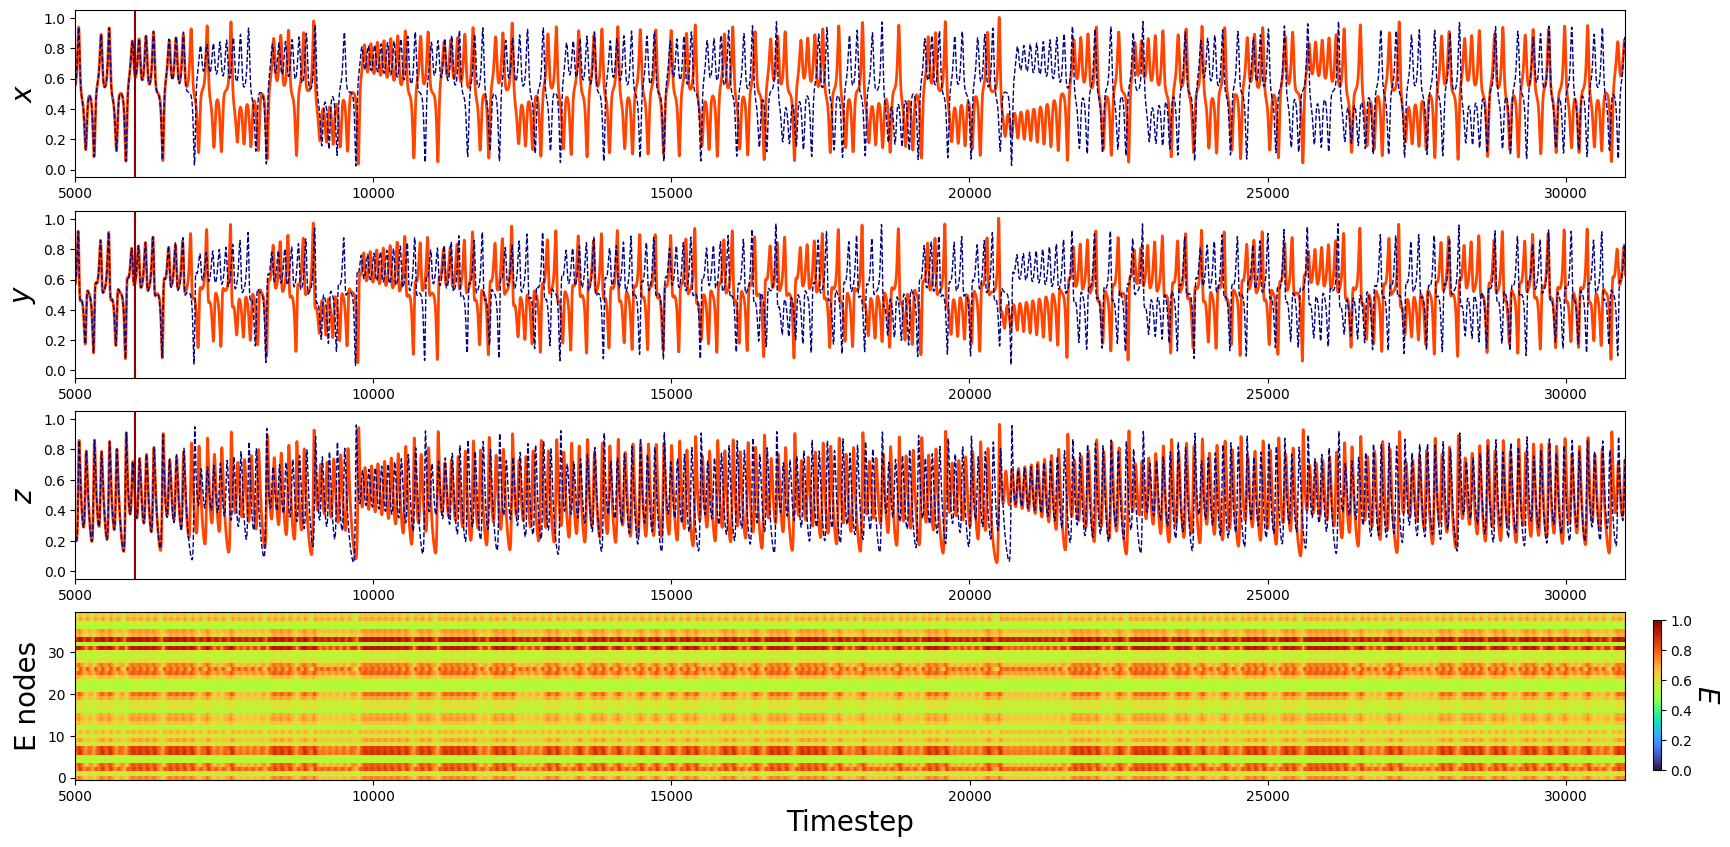

In [43]:
E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start,
                                             idx_echo = idx_echo, plot = True)

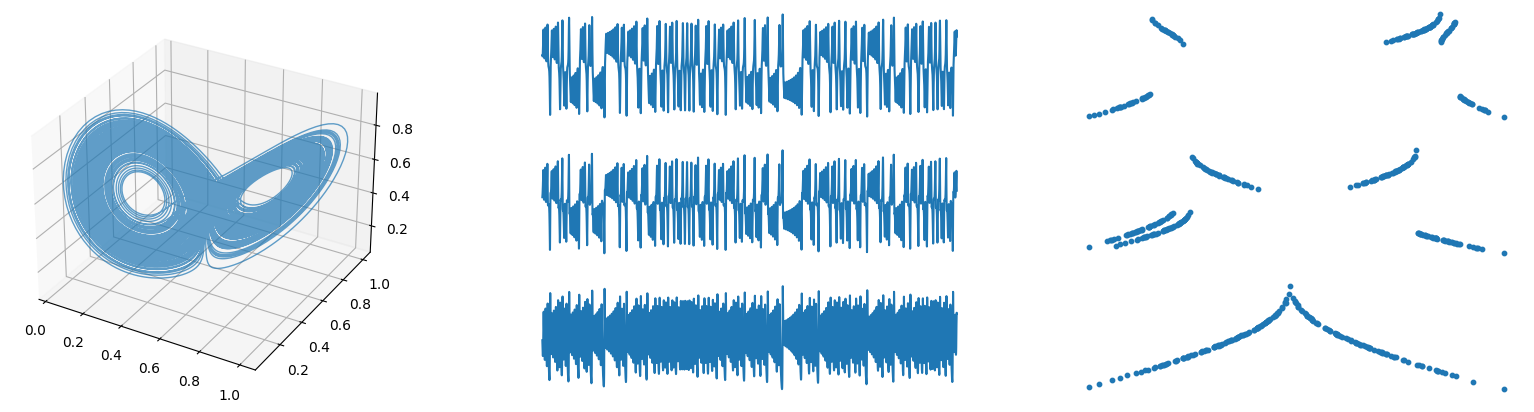

In [44]:
net.plot_attractor(output_echo[idx_echo:])

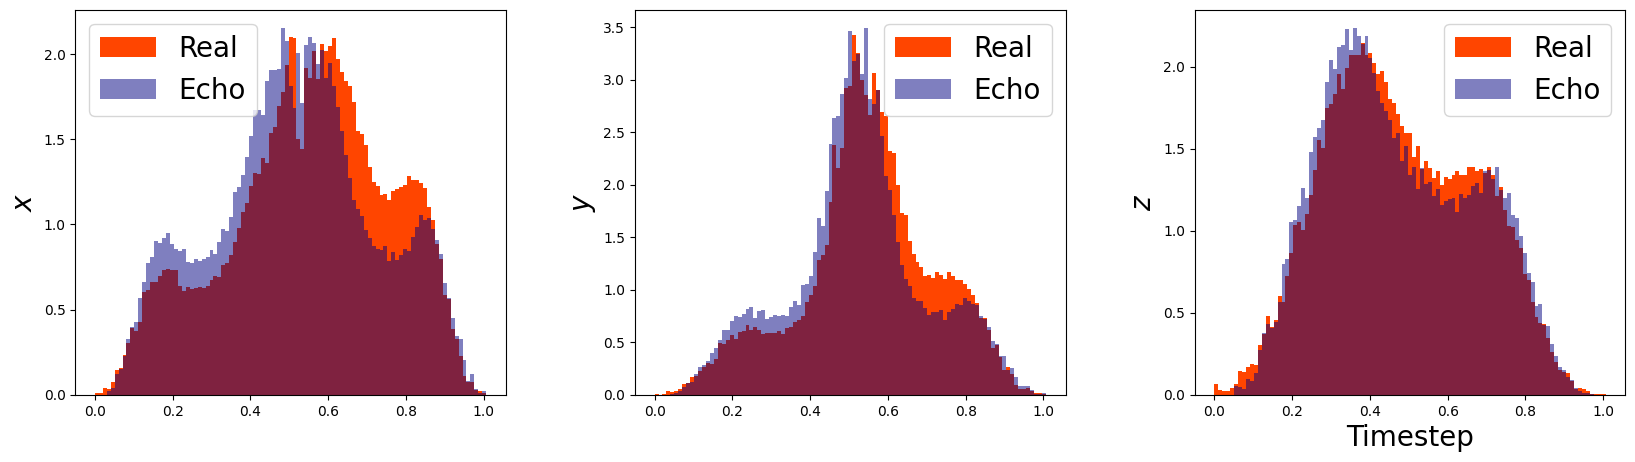

In [45]:
_ = net.compare_results(xyz, output_echo[idx_echo:], NBins = 100)

# Plasticity

In [19]:
N = 250
NE = int(0.8*N)
NI = int(0.2*N)
NIpunts = 3

dt = 0.5

tau_E = 2
tau_I = 2

net = RateNet(NE, NI, NIpunts, dt, tau_E, tau_I, burnSteps = None, input_sparse = 0.5, max_bias = 2)

In [20]:
eta_EE = 1e-2
eta_II = 1e-2
eta_EI = 1e-2
eta_IE = 1e-2

rho_E = 0.5
rho_I = 1

net._set_plasticity(eta_EE, eta_EI, eta_IE, eta_II, rho_E, rho_I)

net.run_plasticity(xyz[:10000])

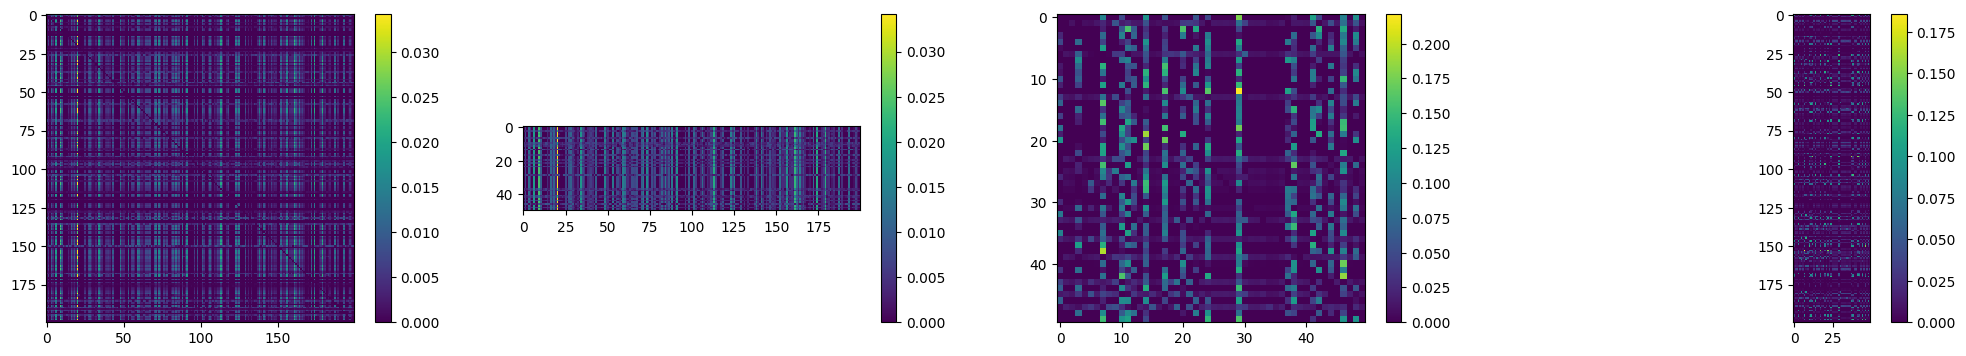

In [21]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (25,4))
for ax, mat in zip(axs, [net.WEE, net.WIE, net.WII, net.WEI]):
    im = ax.imshow(mat, interpolation = 'None', vmin = 0)
    plt.colorbar(im, ax = ax)
plt.show()

1.200594532252926
0.0002844226218390906


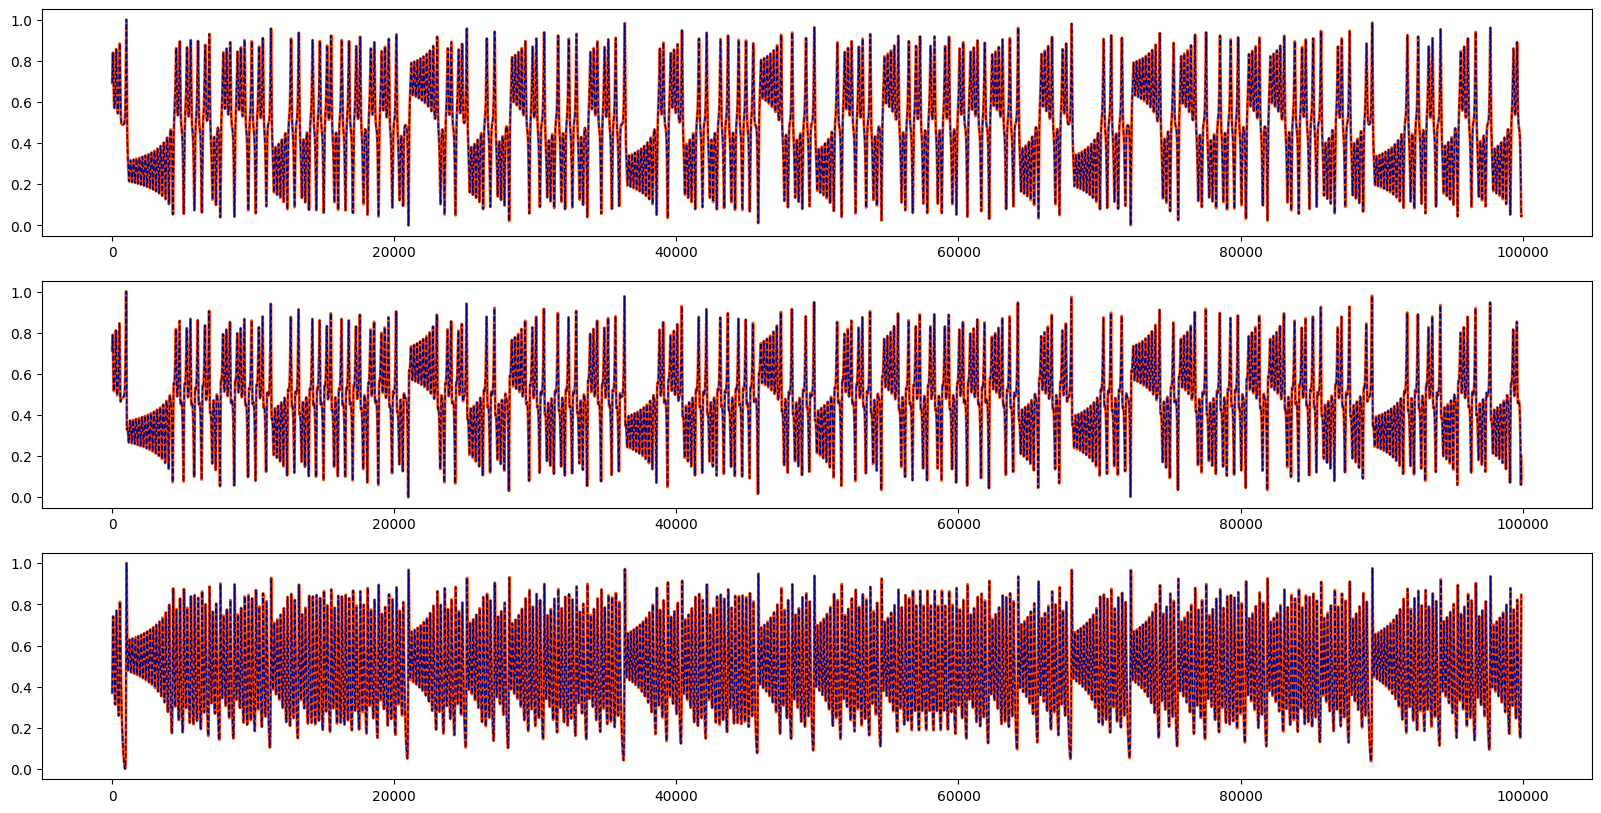

In [22]:
initTraining = 100
MSE, trained_output = net.train_model(xyz, initTraining, alpha = 1e-4)

print(net.Wout.max())
print(MSE)

In [23]:
idx_start = 8000
idx_echo = 7000
nLoops = 100000
E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start, idx_echo = idx_echo)

100%|██████████| 100000/100000 [00:47<00:00, 2120.25it/s]


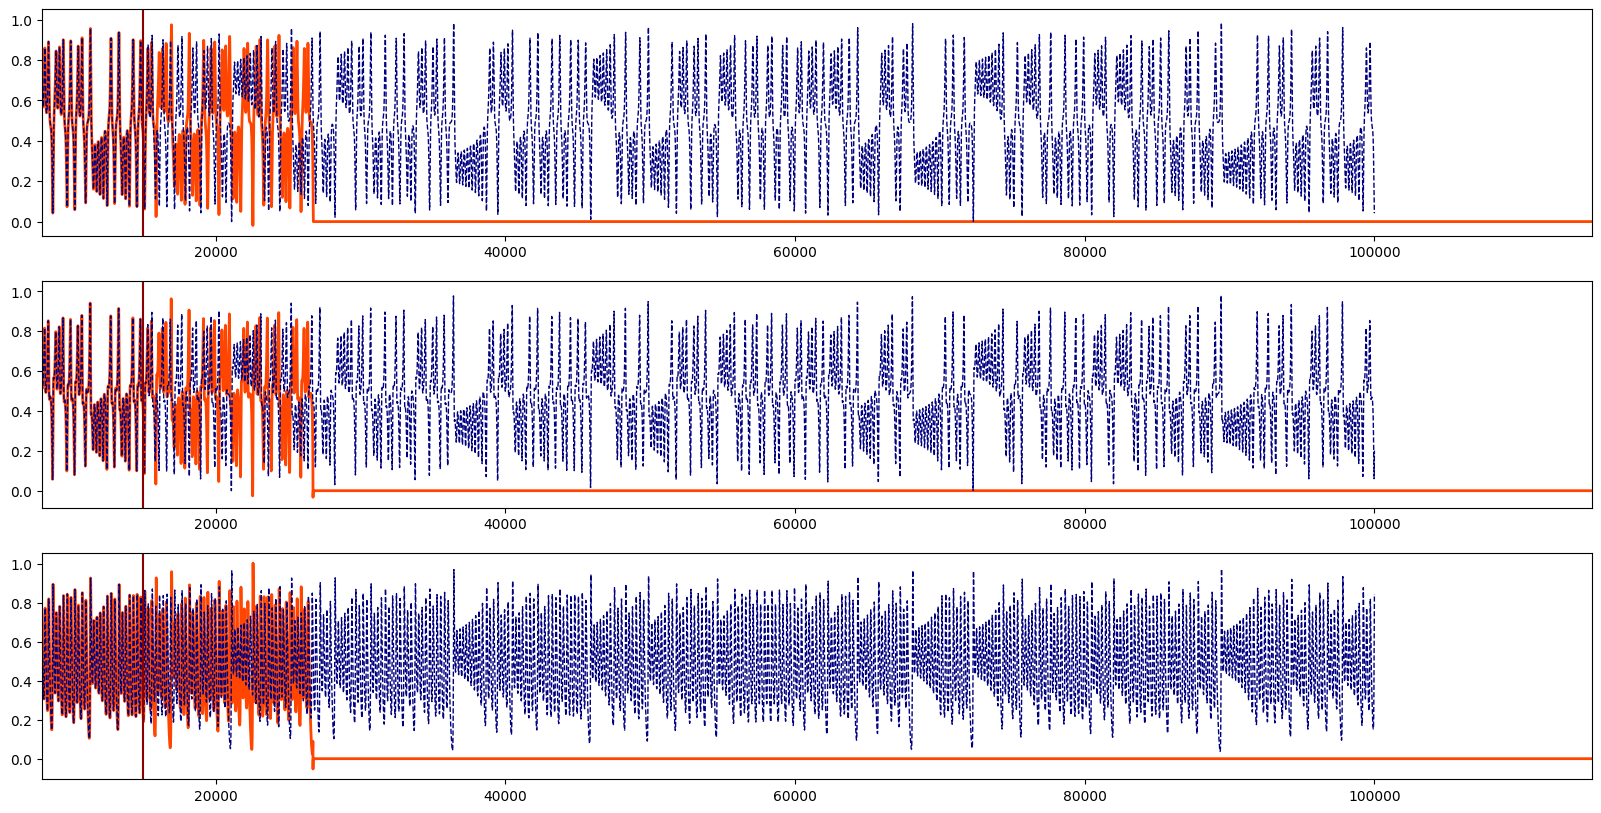

In [24]:
Steps = np.arange(idx_start, idx_start + idx_echo + nLoops + 1)

fig, axs = plt.subplots(figsize = (20,10), nrows = 3)
for i in range(3):
    axs[i].plot(Steps, output_echo[:, i], c = 'orangered', lw = 2)
    axs[i].plot(np.arange(xyz.shape[0]), xyz[:, i], ls = '--', c = 'navy', lw = 1)
    axs[i].axvline(idx_start + idx_echo, c = 'darkred')
    axs[i].set_xlim(idx_start, idx_start + idx_echo + nLoops + 1)
    
#axs[-1].pcolormesh(Steps, np.arange(NE), E_echo.T, cmap = "turbo", shading = 'auto')
plt.show()

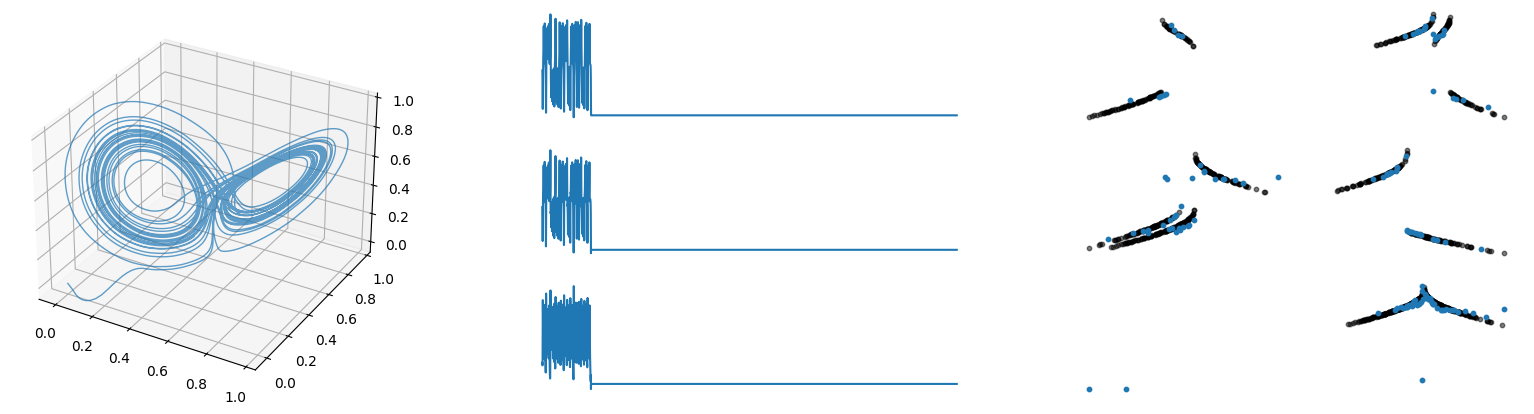

In [25]:
fig = plt.figure(figsize = (20,5))
axs = fig.subplot_mosaic('A03;A14;A25')
ss = axs['A'].get_subplotspec()
axs['A'].remove()
axs['A'] = fig.add_subplot(ss, projection='3d')
axs['A'].plot(*output_echo[idx_echo:].T, alpha=0.7, linewidth=1)

for i in range(3):
    axs[str(i)].plot(output_echo[idx_echo:,i])
    axs[str(i)].axis('off')
    axs[str(i + 3)].scatter(*utils.return_map(xyz[:,i]), s = 10, alpha = 0.5, color = 'black')
    axs[str(i + 3)].scatter(*utils.return_map(output_echo[idx_echo:,i]), s = 10)
    axs[str(i + 3)].axis('off')
plt.show()

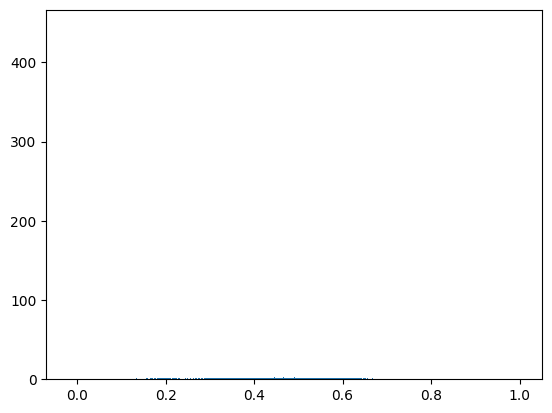

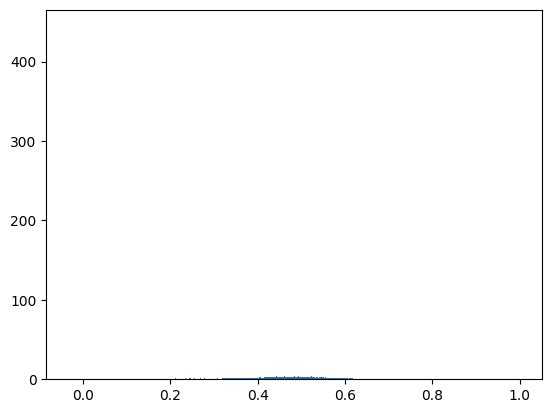

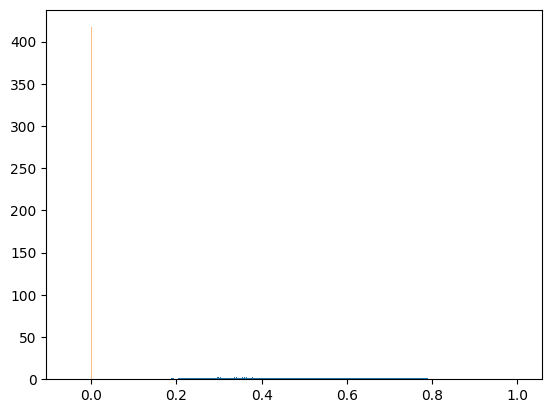

In [26]:
for i in range(3):
    plt.hist(xyz[:,i], density = True, bins = 500)
    plt.hist(output_echo[idx_echo:,i], density = True, bins = 500, alpha = 0.5)
    plt.show()

In [144]:
@njit
def nonlinear_function(x):
    return np.tanh(x)

@njit
def dynamical_step(x, W, dt, tau, nonlinear_function):
    return x + dt * ( -x + nonlinear_function(W @ x) ) / tau

x = np.random.randn(10)
W = np.random.randn(10,10)

In [146]:
%timeit dynamical_step(x, W, dt = 0.1, tau = 1, nonlinear_function = nonlinear_function)

8.15 µs ± 169 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
